<a href="https://colab.research.google.com/github/danjohnvelasco/AI-Playground/blob/master/Logistic_Regression_(MNIST).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression

Logistic regression is also known as a one-layer neural net which means it has no non-linearity at all. Yes, it's a linear model.

Judging by the looks of a sigmoid function, it really doesn't look linear at all.

But it turns out that it really is just a linear model.

**I'll dig deeper into this later.**

# Getting back to work:

Read [this](https://sebastianraschka.com/faq/docs/logistic_regression_linear.html#:~:text=The%20short%20answer%20is%3A%20Logistic,of%20the%20inputs%20and%20parameters.&text=Logistic%20regression%20is%20an%20algorithm%20that%20learns%20a%20model%20for%20binary%20classification)

In [ ]:
%matplotlib inline
from fastai.basics import *

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# Navigate to your directory
%cd "/content/gdrive/My Drive/datasets/MNIST/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/datasets/MNIST


In [ ]:
from pathlib import Path
path = "/content/gdrive/My Drive/datasets/MNIST/"
path = Path(path)

In [ ]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

(50000, 784)

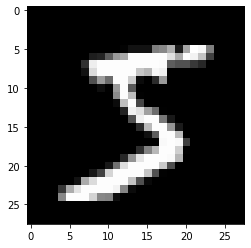

In [ ]:
plt.imshow(x_train[0].reshape((28,28)), cmap="gray")
x_train.shape

In [ ]:
# Convert to tensors
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape # n == number of samples, c == columns/features
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In [ ]:
# Create PyTorch dataset
bs=64 # batch size
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid) # PyTorch function
data = DataBunch.create(train_ds, valid_ds, bs=bs) # fastai function

Remember a dataset is something where if you index into it, you get back an x value and a y value - just one of them.

TensorDataset[i] returns a tuple which contains the data.

DataBunch is a class which creates a dataloader inside. It's just a convenience function to make sure that the data is shuffled, goes into GPU, etc. 

A dataloader is something that you just call "next" to return the x,y of a minibatch.

Functions used:
- iter() - python built-in which returns an iterator
- next(iterator) - python built0in which returns the next item from the iterator

In [ ]:
# 784 values == flattened 28 x 28 pixel values
train_ds[0][0], train_ds[0][0].shape

In [ ]:
# Get minibatch of size 64
x,y = next(iter(data.train_dl))
x.shape,y.shape # Returns (batchsize, flattened 28 x 28), (# of output)

(torch.Size([64, 784]), torch.Size([64]))

In [ ]:
# Create own model
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        # PyTorch modules acts like a function e.g. self.lin(xb)
        self.lin = nn.Linear(784, 10, bias=True)

    # xb is a minibatch of x
    def forward(self, xb): return self.lin(xb)

In [ ]:
# Manually set the model to use the GPU
model = Mnist_Logistic().cuda()

In [ ]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [ ]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [ ]:
loss_func = nn.CrossEntropyLoss()

In [ ]:
def update(x,y,lr):
    wd = 1e-5
    y_hat = model(x)
    # weight decay
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

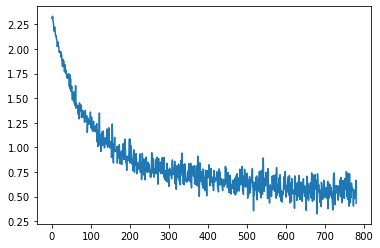

In [ ]:
lr = 2e-2
losses = [update(x,y,lr) for x,y in data.train_dl]
plt.plot(losses)